# Practice Session 03: Find near-duplicates using shingling

Author: <font color="blue">José María Pérez Clar</font>

E-mail: <font color="blue">josemaria.perez02@estudiant.upf.edu</font>

Date: <font color="blue">11/10/2023</font>

In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [ ]:
# "CovidLockdownCatalonia.json.gz" available at https://drive.google.com/file/d/1u3VznvrxA4lfWfuJTKg0y3fVXsVULq0D/view?usp=sharing

In [2]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

In [3]:
def jaccard_similarity(l1, l2):
    set1 = set(l1)
    set2 = set(l2)
    a = len(set1.intersection(set2))
    b = len(set1.union(set2))
    
    if (b==0):
        return 0
    
    return a/b

In [4]:
l1 = ['a', 'b', 'c', 'e' , 'f']
l2 = ['a', 'b', 'c', 'd' , 'f']
result1 = jaccard_similarity(l1, l2)
print("The first comparison has a jaccard similarity of: ", result1)

l3 = ['a', 'b', 'c', 'e' , 'f' , 'g','h']
l4 = ['a', 'b', 'c', 'd' , 'f' ,'g','h']
result2 = jaccard_similarity(l3, l4)
print("The second comparison has a jaccard similarity of: ", result2)

l5 = ['a', 'b', 'c' , 'd', 'e']
l6 = ['a', 'b', 'c' , 'd', 'e']
result3 = jaccard_similarity(l5, l6)
print("The third comparison has a jaccard similarity of: ", result3)



l7 = []
l8 = []
result4 = jaccard_similarity(l7, l8)
print("The fourth comparison has a jaccard similarity of: ", result4)

The first comparison has a jaccard similarity of:  0.6666666666666666
The second comparison has a jaccard similarity of:  0.75
The third comparison has a jaccard similarity of:  1.0
The fourth comparison has a jaccard similarity of:  0


In [52]:
def clean(text):
    char_wrong = ['Ñ','ñ','ó','à','ò','í','è','é','ú','l·l','L·L','ç','Ç']
    char_right = ['n','n','o','a','o','i','e','e','u','ll','ll','c','c'] 
    
    text = re.sub(r'^RT ', '', text)
    text = text.lower()
    for char in range(len(char_wrong)):                                             
        text = re.sub(char_wrong[char], char_right[char], text)
    text = re.sub(r'https?://\S+', '', text)
    text = text.strip()
    text = re.sub(r'[^a-z0-9 ]', '', text)
    text = re.sub(r'  +', ' ', text)
    
    return text

text1 = "RT This is the first example of José!"
text2 = "CHANGE text and   Multiple   Spaces and paral·lelize"
text3 = "12345 test 4 special characters: @#$%&*}()-_+"
text4 = "https://www.ex1.com and http://ex2.es"
text5 = "  Too many   spaces  in this text "

cleaned_text1 = clean(text1)
cleaned_text2 = clean(text2)
cleaned_text3 = clean(text3)
cleaned_text4 = clean(text4)
cleaned_text5 = clean(text5)

print("Original Text 1:", text1)
print("Cleaned Text 1:", cleaned_text1)
print("\nOriginal Text 2:", text2)
print("Cleaned Text 2:", cleaned_text2)
print("\nOriginal Text 3:", text3)
print("Cleaned Text 3:", cleaned_text3)
print("\nOriginal Text 4:", text4)
print("Cleaned Text 4:", cleaned_text4)
print("\nOriginal Text 5:", text5)
print("Cleaned Text 5:", cleaned_text5)

Original Text 1: RT This is the first example of José!
Cleaned Text 1: this is the first example of jose

Original Text 2: CHANGE text and   Multiple   Spaces and paral·lelize
Cleaned Text 2: change text and multiple spaces and parallelize

Original Text 3: 12345 test 4 special characters: @#$%&*}()-_+
Cleaned Text 3: 12345 test 4 special characters 

Original Text 4: https://www.ex1.com and http://ex2.es
Cleaned Text 4: and

Original Text 5:   Too many   spaces  in this text 
Cleaned Text 5: too many spaces in this text


# 2. Implement an n-gram extractor

In [6]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []
    rightsize_tokens = []
    
    for token in tokens:
        if len(token)>= MIN_TOKEN_LENGTH:
            rightsize_tokens.append(token)

    if size <= len(rightsize_tokens):
        for i in range(len(rightsize_tokens) - size + 1):
            ngram = ' '.join(rightsize_tokens[i:i+size])
            ngrams.append(ngram)
    
    return ngrams

In [7]:
print(messages[9780])
print(ngrams(messages[9780], 3))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants xinesos', 'comerciants xinesos donen', 'xinesos donen mascaretes', 'donen mascaretes gel', 'mascaretes gel antiseptic', 'gel antiseptic badalona', 'antiseptic badalona per', 'badalona per lluitar', 'per lluitar contra', 'lluitar contra coronavirus']


# 3. Estimation for brute force method

In [8]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

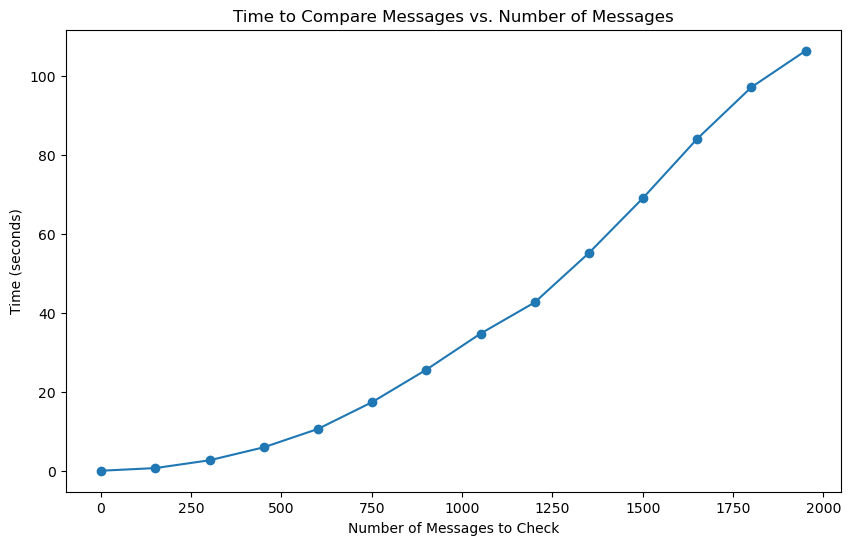

In [44]:
x_values = []
y_values = []

for limit in range(1, 2002, 150):
    time_taken = time_brute_force_similarities(messages, limit, ngram_size=4)
    x_values.append(limit)
    y_values.append(time_taken)

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.title('Time to Compare Messages vs. Number of Messages')
plt.xlabel('Number of Messages to Check')
plt.ylabel('Time (seconds)')

plt.show()

The plot shows that the time it takes to check the messages incresases at something similar to an exponential rate at first, but that stabilises later. Finding the time it will take analytically is very hard, nonetheless, we can make a decent estimation. Knowing that checking about 2000 messages takes about 110 seconds and the slope is decreasing to the point that we can see it already is about m=(110-90/1950-1800), we could place an upper bound and say that if the function keeps increasing as it is and does not decrease its growth anymore (which is what seems is going to happen), moving forward 8000 messages would mean moving up (110-90/1950-1800)x8000 = 1066.6 seconds.

With this information, assuming the function will increase monotonously from 2000 on, we could place an estimation around 1176 seconds for the 10000 messages. This comes out to be 0 hours, 19 minutes and 36 seconds.

# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [54]:
NGRAM_SIZE = 4

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram not in ngram_to_index: #we know that if it is in one dictionary it will also be in the other
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index += 1

num_distinct_ngrams = next_index
print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 54014 distinct ngrams in the 10000 documents


In [57]:
a = index_to_ngram[100]
print(a)
print(ngram_to_index[a])

vilaweb coronavirus lhora treure
100


## 2.2 Create table ngrams x documents

In [58]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 54014 rows (distinct shingles) x 10000 columns (distinct documents)


In [61]:
counter = 0
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        M_ngram_doc[ngram_to_index[ngram]][docid] = True
        counter +=1      

In [66]:
total_cells = M_ngram_doc.size
density = (counter / total_cells) * 100
print("Matrix Density:", density, "%")

Matrix Density: 0.020328803643499833 %


In [76]:
def print_column(id):
    print('\n')
    print('Positions of non-zeros in column of docid ',id,' of M_ngram_doc')
    print("\nClean message:\n",clean(messages[id]))
    row_ = 0
    print('\nNon-zeros in corresponding row:')
    for row in M_ngram_doc:
        if row[id]:
            print(row_, '[',index_to_ngram[row_],']')
        row_+=1
        
    print('\n----------------------------------------------------------------------------')
        
#TEST THE FUNCTION
print_column(9602)
print_column(941)



Positions of non-zeros in column of docid  9602  of M_ngram_doc

Clean message:
 emergenciescat que puc fer i que no faqs del coronavirus a 14 de marc si us plau demanem difusio

Non-zeros in corresponding row:
861 [ emergenciescat que puc fer ]
862 [ que puc fer que ]
31086 [ puc fer que faqs ]
31087 [ fer que faqs del ]
31088 [ que faqs del coronavirus ]
31089 [ faqs del coronavirus marc ]
31090 [ del coronavirus marc plau ]
31091 [ coronavirus marc plau demanem ]
31092 [ marc plau demanem difusio ]

----------------------------------------------------------------------------


Positions of non-zeros in column of docid  941  of M_ngram_doc

Clean message:
 hospiolot usem de forma responsable els recursos sanitaris061 urgencies per coronavirus i sanitaries012 consultes general

Non-zeros in corresponding row:
1054 [ usem forma responsable els ]
1055 [ forma responsable els recursos ]
1056 [ responsable els recursos sanitaris061 ]
1057 [ els recursos sanitaris061 urgencies ]
1058 [ r

# 3. Implement a permutation generator

In [16]:
def random_permutation(k):
    permutation = list(range(k))
    random.shuffle(permutation)
    return permutation

test_permut = random_permutation(20)
print(test_permut)

[16, 1, 7, 10, 18, 15, 11, 12, 5, 4, 2, 0, 8, 13, 17, 14, 6, 3, 19, 9]


In [17]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['3 (test3)', '2 (test2)', '1 (test1)', '5 (test5)', '4 (test4)']
['3 (beta)', '2 (gamma)', '1 (alpha)', '5 (epsilon)', '4 (delta)']

Test another permutation
['2 (test2)', '4 (test4)', '1 (test1)', '3 (test3)', '5 (test5)']
['2 (gamma)', '4 (delta)', '1 (alpha)', '3 (beta)', '5 (epsilon)']


# 4. Compute the signature of each document

In [18]:
# Leave this code as-is

NUM_PERMUTATIONS = 5
permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))

# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 44080, 6902, 14180, ...
Permutation 1: 30935, 10025, 1528, ...
Permutation 2: 12567, 46375, 41758, ...
Permutation 3: 20943, 32296, 19054, ...
Permutation 4: 34719, 39916, 16685, ...


In [19]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        
        first_ngram_id = find_first_one(docid, permutation)
        if first_ngram_id != -1:
            M_signature_doc[permutation_num, docid] = first_ngram_id

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [20]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat el govern de la gencat anuncia el confinament de tot catalunyadavant lemergencia de la covid19 el missatge es clau
Ngrams        : [3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616]
Signature     : [3609.0, 3611.0, 3612.0, 3613.0, 3609.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicatcoronavirus el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau limitar la mobilitat ajudara a evitar la propagacio del coronavirus evitem desplaaments i redum la vida social

# 5. Compare all pairs of signatures

In [43]:
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

    # Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1 + 1, len(messages)):

            # If this has not already been marked as a duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                similarity = jaccard_similarity(set(signature1), set(signature2))
                
                if similarity == 1:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = docid1
                    
                elif similarity > 0.2:
                    count_sig_partial_matches += 1
                    is_possible_duplicate[docid2] = docid1


        # Check if doc1 is a possible duplicate of any document
        if (count_sig_partial_matches + count_sig_full_matches) >= 50:
            print('The document' , docid1, 'has', count_sig_full_matches , 'full matches and' , count_sig_partial_matches, 'partial matches')
            print(messages[docid1])
            print('-------------------------------\n')

0/10000 documents scanned
The document 16 has 71 full matches and 0 partial matches
RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
-------------------------------

The document 42 has 46 full matches and 6 partial matches
RT @VilaWeb: Els @mossos diuen que és més senzill confinar el Principat que diverses ciutats a la vegada https://t.co/piyLz82e9d
-------------------------------

The document 53 has 57 full matches and 0 partial matches
RT @Oriol_Pintos: Sóc advocat laboralista. Davant aquesta situació d'incertesa jurídica generalitzada pel #Coronavirus que afecta i afectar…
-------------------------------

The document 77 has 6 full matches and 177 partial matches
RT @emergenciescat: ✅ Què puc fer i ⛔ què no si estic en una zona afectada pel confinament? 

#ProteccioCivil #Coronavirus https://t.co/lxz…
-------------------------------

The document 166 has 56 full matches and 0 partial matche

The document 16 has 71 full matches and 0 partial matches
RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…

This tweet is an emergency message that was emited by an official organism, so it is being re-tweeted many times so that it can reach as many people as possible but the information of the message is not being altered because the goal is not to share an opinion on the topic but to spread the message. 

In [40]:
print('Original Document:\n', messages[77])
print('Partial Match Document:\n', messages[1174])

Original Document:
 RT @emergenciescat: ✅ Què puc fer i ⛔ què no si estic en una zona afectada pel confinament? 

#ProteccioCivil #Coronavirus https://t.co/lxz…
Partial Match Document:
 RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…


Original Document:
 RT @emergenciescat: ✅ Què puc fer i ⛔ què no si estic en una zona afectada pel confinament? 
#ProteccioCivil #Coronavirus https://t.co/lxz…

Partial Match Document:
 RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…

In this case, we see two tweets on the topic of the coronavirus. Logically, since they talk about the same thing they have many similarities (in both cases they're talking about what or what not to do) but since they are substantially different, we can only consider them very related tweets that are not duplicates of each other.


<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>